<a href="https://colab.research.google.com/github/fmejias/CienciasDeLosDatosTEC/blob/master/MatematicasCienciasDeLosDatos/TP4/TP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matemáticas para Ciencias de los Datos
# Trabajo práctico 4

- Professor: M.Sc.Saul Calderon.

- Students: 
    - María Auxiliadora Mora, Instituto Tecnológico de Costa Rica  
    - Felipe Alberto Mejías Loría, Instituto Tecnológico de Costa Rica. 

- June 15th, 2019   

In [0]:
# Libraries required for the exercises
from __future__ import print_function
import torch as torch
import numpy as np
import random
import math
from sympy import *

import torch.distributions as distrib

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from numpy import linalg as linalg

from torch.distributions import constraints
from torch.distributions.distribution import Distribution
from torch.distributions.utils import _standard_normal, lazy_property
import torch.distributions as distrib
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal

from sklearn.model_selection import train_test_split as tts

# 1) Optimización de funciones (100 puntos)



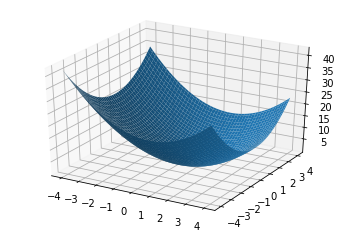

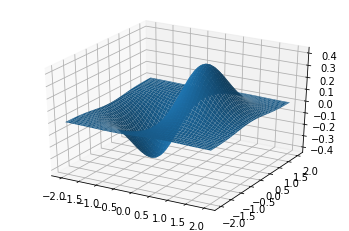

In [0]:
def optimizacion():  
  # Exercise 1.a
  def plot_func1():
    """
    Graph the surface
    """
    def f_a(x,y):
      return ((np.power(x-0.7, 2))+(np.power(y-0.5, 2)))

    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)

    X, Y = np.meshgrid(x, y)
    Z = f_a(X,Y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z)

    plt.show()
    
  def plot_func2():
    """
    Graph the surface
    """
    def f_b(x,y):
      exp = -np.power(x, 2)-np.power(y, 2)
      return x*(np.power(2.71828, exp))

    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)

    X, Y = np.meshgrid(x, y)
    Z = f_b(X,Y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z)

    plt.show()
    
  # Plot both functions
  plot_func1()
  plot_func2()

# Plot exercise 4.2.a
optimizacion()
  
  
 

# 2) Implemente el algoritmo del descenso del gradiente (50 puntos)

-----------------------------------------------
Gradient Descent for Function 1
Resultado para la corrida = 1
Function = (x - 0.7)**2 + (y - 0.5)**2
Initial Point in X(x0) = 3.000000
Initial Point in Y(y0) = 3.000000
Number of iterations = 60
Minimum value found in X(x0) = 0.700004
Minimum value found in Y(y0) = 0.500004
Correct value in X(x0) = 0.7
Correct value in Y(y0) = 0.5

Resultado para la corrida = 2
Function = (x - 0.7)**2 + (y - 0.5)**2
Initial Point in X(x0) = 2.000000
Initial Point in Y(y0) = 2.000000
Number of iterations = 58
Minimum value found in X(x0) = 0.700003
Minimum value found in Y(y0) = 0.500004
Correct value in X(x0) = 0.7
Correct value in Y(y0) = 0.5

Resultado para la corrida = 3
Function = (x - 0.7)**2 + (y - 0.5)**2
Initial Point in X(x0) = 1.000000
Initial Point in Y(y0) = 1.000000
Number of iterations = 53
Minimum value found in X(x0) = 0.700002
Minimum value found in Y(y0) = 0.500004
Correct value in X(x0) = 0.7
Correct value in Y(y0) = 0.5

Resultado para

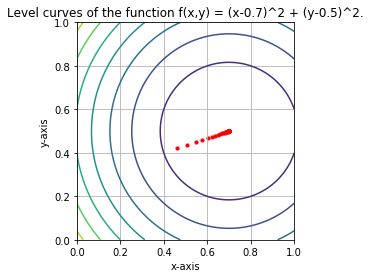

-----------------------------------------------
Gradient Descent for Function 2
Resultado para la corrida = 1
Function = 2.71828182845905**(-x**2 - y**2)*x
Initial Point in X(x0) = 1.300000
Initial Point in Y(y0) = 1.300000
Too many iterations

Resultado para la corrida = 2
Function = 2.71828182845905**(-x**2 - y**2)*x
Initial Point in X(x0) = 2.000000
Initial Point in Y(y0) = 2.000000
Too many iterations

Resultado para la corrida = 3
Function = 2.71828182845905**(-x**2 - y**2)*x
Initial Point in X(x0) = 1.000000
Initial Point in Y(y0) = 1.000000
Too many iterations

Resultado para la corrida = 4
Function = 2.71828182845905**(-x**2 - y**2)*x
Initial Point in X(x0) = 0.000000
Initial Point in Y(y0) = 0.000000
Number of iterations = 63
Minimum value found in X(x0) = -0.707102
Minimum value found in Y(y0) = 0.000000
Correct value in X(x0) = 0.707
Correct value in Y(y0) = 0.0

Resultado para la corrida = 5
Function = 2.71828182845905**(-x**2 - y**2)*x
Initial Point in X(x0) = -1.000000
In

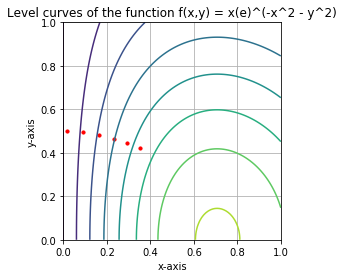

In [0]:
def plotLevelCurve(plotPoints, plotFunction1=False, plotFunction2=False):  
  # Exercise 1.a
  def plot_func1():
    """
    Graph the surface
    """
    def f_a(x,y):
      return ((np.power(x-0.7, 2))+(np.power(y-0.5, 2)))

    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)

    X, Y = np.meshgrid(x, y)
    Z = f_a(X,Y)
    
    plt.contour(X, Y, Z)
    plt.grid(True)
    plt.axis('scaled')
    
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.title('Level curves of the function f(x,y) = (x-0.7)^2 + (y-0.5)^2.')
    
    plt.scatter(plotPoints[0], plotPoints[1], s=10, c='r', marker='o')
      

    plt.show()
    
  def plot_func2():
    """
    Graph the surface
    """
    def f_b(x,y):
      exp = -np.power(x, 2)-np.power(y, 2)
      return x*(np.power(2.71828, exp))

    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)

    X, Y = np.meshgrid(x, y)
    Z = f_b(X,Y)
    
    plt.contour(X, Y, Z)
    plt.grid(True)
    plt.axis('scaled')
    
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.title('Level curves of the function f(x,y) = x(e)^(-x^2 - y^2)')
    
    plt.scatter(plotPoints[0], plotPoints[1], s=10, c='r', marker='o')
      

    plt.show()
    
  # Plot both functions
  if plotFunction1:
    plot_func1()
  if plotFunction2:
    plot_func2()

def funct1():
  x = Symbol('x')
  y = Symbol('y')
  return (x-0.7)**2 + (y-0.5)**2

def funct2():
  x = Symbol('x')
  y = Symbol('y')
  return x * ((N(E))**(-x**2 -y**2))

def gradient_descent(function, previousX, previousY, run=0, plotFunction1=False, plotFunction2=False, alpha = 0.1):
  x = Symbol('x')
  y = Symbol('y')
  
  # First partial derivative with respect to x
  fdx = function.diff(x)

  # First partial derivative with respect to y
  fdy = function.diff(y)
  
  # Initialize Parameters
  iterations = 0
  precision = 1/1000000
  maximumIterations = 1000
  testedPointsX = []
  testedPointsY = []
  
  # Print base values
  print('Resultado para la corrida = %d' % run)
  print('Function = %s' % function)
  print('Initial Point in X(x0) = %f' % (previousX))
  print('Initial Point in Y(y0) = %f' % (previousY))
  
  
  while True:
    gradientX = N(fdx.subs(x, previousX).subs(y, previousY)).evalf()
    gradientY = N(fdy.subs(y, previousY)).subs(x, previousX).evalf()
    currentX  = previousX - alpha * gradientX
    currentY  = previousY - alpha * gradientY
    
    # Append plot points
    testedPointsX.append(currentX)
    testedPointsY.append(currentY)

    # Stop the loop due to so many iterations
    iterations += 1
    if iterations > maximumIterations:
      print("Too many iterations\n")
      break

    if abs(currentX - previousX) <= precision and abs(currentY - previousY) <= precision:
      print('Number of iterations = %d' % (iterations))
      print('Minimum value found in X(x0) = %f' % (currentX))
      print('Minimum value found in Y(y0) = %f' % (currentY))
      if function == funct1():
        print('Correct value in X(x0) = 0.7')
        print('Correct value in Y(y0) = 0.5\n')
      if function == funct2():
        print('Correct value in X(x0) = 0.707')
        print('Correct value in Y(y0) = 0.0\n')
      
      # Plot surface 
      plotLevelCurve([testedPointsX, testedPointsY], plotFunction1, plotFunction2)
      break

    # Update x and y parameters
    previousX = currentX
    previousY = currentY
    
  
    
# Test gradient descent for Function 1
print("-----------------------------------------------")
print("Gradient Descent for Function 1")
gradient_descent(funct1(), previousX = 3, previousY = 3, run=1)
gradient_descent(funct1(), previousX = 2, previousY = 2, run=2)
gradient_descent(funct1(), previousX = 1, previousY = 1, run=3)
gradient_descent(funct1(), previousX = 0, previousY = 0, run=4)
gradient_descent(funct1(), previousX = -1, previousY = -1, run=5)
gradient_descent(funct1(), previousX = -2, previousY = -2, run=6)
gradient_descent(funct1(), previousX = -3, previousY = -3, run=7)
gradient_descent(funct1(), previousX = 1.3, previousY = 1.3, run=8)
gradient_descent(funct1(), previousX = 0.3, previousY = 0.3, run=9)
gradient_descent(funct1(), previousX = 0.4, previousY = 0.4, run=10, plotFunction1=True)

# Test gradient descent for Function 2
print("-----------------------------------------------")
print("Gradient Descent for Function 2")
gradient_descent(funct2(), previousX = 1.3, previousY = 1.3, run=1)
gradient_descent(funct2(), previousX = 2, previousY = 2, run=2)
gradient_descent(funct2(), previousX = 1, previousY = 1, run=3)
gradient_descent(funct2(), previousX = 0, previousY = 0, run=4)
gradient_descent(funct2(), previousX = -1, previousY = -1, run=5)
gradient_descent(funct2(), previousX = -2, previousY = -2, run=6)
gradient_descent(funct2(), previousX = -1.4, previousY = -1.4, run=7)
gradient_descent(funct2(), previousX = 1.3, previousY = 1.3, run=8)
gradient_descent(funct2(), previousX = 0.3, previousY = 0.3, run=9)
gradient_descent(funct2(), previousX = 0.4, previousY = 0.4, run=10, plotFunction2=True)


#3) Implemente el algoritmo de Newton-Raphson, para cada función. (40 puntos)

-----------------------------------------------
Newton Raphson for Function 1
Resultado para la corrida = 1
Function = (x - 0.7)**2 + (y - 0.5)**2
Initial Point in X(x0) = 3.000000
Initial Point in Y(y0) = 3.000000
Number of iterations = 2
Minimum value found in X(x0) = 0.700000
Minimum value found in Y(y0) = 0.500000
Correct value in X(x0) = 0.7
Correct value in Y(y0) = 0.5

Resultado para la corrida = 2
Function = (x - 0.7)**2 + (y - 0.5)**2
Initial Point in X(x0) = 2.000000
Initial Point in Y(y0) = 2.000000
Number of iterations = 2
Minimum value found in X(x0) = 0.700000
Minimum value found in Y(y0) = 0.500000
Correct value in X(x0) = 0.7
Correct value in Y(y0) = 0.5

Resultado para la corrida = 3
Function = (x - 0.7)**2 + (y - 0.5)**2
Initial Point in X(x0) = 1.000000
Initial Point in Y(y0) = 1.000000
Number of iterations = 2
Minimum value found in X(x0) = 0.700000
Minimum value found in Y(y0) = 0.500000
Correct value in X(x0) = 0.7
Correct value in Y(y0) = 0.5

Resultado para la c

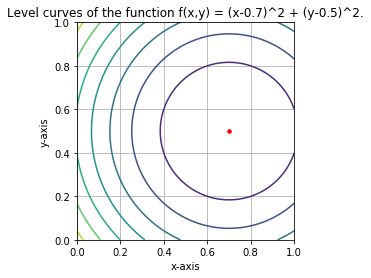

-----------------------------------------------
Newton Raphson for Function 2
Resultado para la corrida = 1
Function = 2.71828182845905**(-x**2 - y**2)*x
Initial Point in X(x0) = 2.000000
Initial Point in Y(y0) = 2.000000
Number of iterations = 5
Minimum value found in X(x0) = 3.230541
Minimum value found in Y(y0) = 3.118226
Correct value in X(x0) = 0.707
Correct value in Y(y0) = 0.0

Resultado para la corrida = 2
Function = 2.71828182845905**(-x**2 - y**2)*x
Initial Point in X(x0) = 1.200000
Initial Point in Y(y0) = 1.200000
Number of iterations = 2
Minimum value found in X(x0) = -5.425116
Minimum value found in Y(y0) = 2.157520
Correct value in X(x0) = 0.707
Correct value in Y(y0) = 0.0

Resultado para la corrida = 3
Function = 2.71828182845905**(-x**2 - y**2)*x
Initial Point in X(x0) = 1.000000
Initial Point in Y(y0) = 1.000000
Number of iterations = 12
Minimum value found in X(x0) = 0.707107
Minimum value found in Y(y0) = 4.014510
Correct value in X(x0) = 0.707
Correct value in Y(y

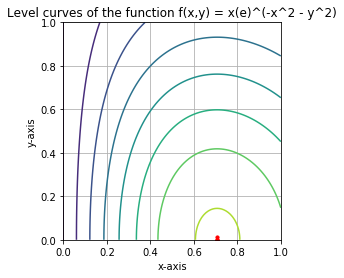

In [0]:
def funct1():
  x = Symbol('x')
  y = Symbol('y')
  return (x-0.7)**2 + (y-0.5)**2

def funct2():
  x = Symbol('x')
  y = Symbol('y')
  return x * ((N(E))**(-x**2 -y**2))

def newton_raphson(function, previousX, previousY, run=0, plotFunction1=False, plotFunction2=False):
  x = Symbol('x')
  y = Symbol('y')
  
  # First partial derivative with respect to x
  fdx = function.diff(x)
  
  # Second partial derivative with respect to x
  second_fdx = fdx.diff(x)

  # First partial derivative with respect to y
  fdy = function.diff(y)
  
  # Second partial derivative with respect to y
  second_fdy = fdy.diff(y)
  
  # Initialize Parameters
  iterations = 0
  precision = 1/1000000
  maximumIterations = 15 
  testedPointsX = []
  testedPointsY = []
  
  # Print base values
  print('Resultado para la corrida = %d' % run)
  print('Function = %s' % function)
  print('Initial Point in X(x0) = %f' % (previousX))
  print('Initial Point in Y(y0) = %f' % (previousY))
  
  while True:
    substituteFirstDerivativeX = N(fdx.subs(x, previousX).subs(y, previousY)).evalf()
    substituteSecondDerivativeX = N(second_fdx.subs(x, previousX).subs(y, previousY)).evalf()
    substituteFirstDerivativeY = N(fdy.subs(y, previousY)).subs(x, previousX).evalf()
    substituteSecondDerivativeY = N(second_fdy.subs(y, previousY)).subs(x, previousX).evalf()
    currentX  = previousX - (substituteFirstDerivativeX/substituteSecondDerivativeX)
    currentY  = previousY - (substituteFirstDerivativeY/substituteSecondDerivativeY)
    
    # Append plot points
    testedPointsX.append(currentX)
    testedPointsY.append(currentY)

    # Stop the loop due to so many iterations
    iterations += 1
    if iterations > maximumIterations:
      print("Too many iterations\n")
      break

    if abs(substituteFirstDerivativeX) <= precision and abs(substituteFirstDerivativeY) <= precision:
      print('Number of iterations = %d' % (iterations))
      print('Minimum value found in X(x0) = %f' % (currentX))
      print('Minimum value found in Y(y0) = %f' % (currentY))
      if function == funct1():
        print('Correct value in X(x0) = 0.7')
        print('Correct value in Y(y0) = 0.5\n')
      if function == funct2():
        print('Correct value in X(x0) = 0.707')
        print('Correct value in Y(y0) = 0.0\n')
      
      # Plot surface 
      plotLevelCurve([testedPointsX, testedPointsY], plotFunction1, plotFunction2)
      break

    # Update x and y parameters
    previousX = currentX
    previousY = currentY
    

# Test gradient descent for Function 1
print("-----------------------------------------------")
print("Newton Raphson for Function 1")
newton_raphson(funct1(), previousX = 3, previousY = 3, run=1)
newton_raphson(funct1(), previousX = 2, previousY = 2, run=2)
newton_raphson(funct1(), previousX = 1, previousY = 1, run=3)
newton_raphson(funct1(), previousX = 0, previousY = 0, run=4)
newton_raphson(funct1(), previousX = -1, previousY = -1, run=5)
newton_raphson(funct1(), previousX = -2, previousY = -2, run=6)
newton_raphson(funct1(), previousX = -3, previousY = -3, run=7)
newton_raphson(funct1(), previousX = 1.3, previousY = 1.3, run=8)
newton_raphson(funct1(), previousX = 0.3, previousY = 0.3, run=9)
newton_raphson(funct1(), previousX = 0.4, previousY = 0.4, run=10, plotFunction1=True)

# Test Newton Raphson for Function 2
print("-----------------------------------------------")
print("Newton Raphson for Function 2")
newton_raphson(funct2(), previousX = 2, previousY = 2, run=1)
newton_raphson(funct2(), previousX = 1.2, previousY = 1.2, run=2)
newton_raphson(funct2(), previousX = 1, previousY = 1, run=3)
newton_raphson(funct2(), previousX = 1.5, previousY = 1.5, run=4)
newton_raphson(funct2(), previousX = -1, previousY = -1, run=5)
newton_raphson(funct2(), previousX = -2, previousY = -2, run=6)
newton_raphson(funct2(), previousX = -1.3, previousY = -1.3, run=7)
newton_raphson(funct2(), previousX = 1.3, previousY = 1.3, run=8)
newton_raphson(funct2(), previousX = 0.3, previousY = 0.3, run=9)
newton_raphson(funct2(), previousX = 0.4, previousY = 0.4, run=10, plotFunction2=True)

# 2. Algoritmo del Perceptrón con descenso del gradiente

In [0]:
#Exercise 2.1
"""
Creates the data to be used for training, using a GMM distribution
@param numberSamplesPerClass, the number of samples per class
@param mean1, means for samples from the class 1
@param mean2, means for samples from the class 2
@param stds1, standard deviation for samples, class 1
@param stds2, standard deviation for samples, class 2
"""
def createData(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [6, 6], stds1 = [3, 3], stds2 = [2, 1]):
    means = torch.zeros(2)

    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]

    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]
    
    samplesClass1 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)

    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]
    samplesClass2 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    
    
    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    
    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1], marker='^', c='red')
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker='o', c='black')

    plt.show()
    #Create samples with bias
    samplesAllBias = torch.cat((samplesClass1Bias, samplesClass2Bias), 0)
    
    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1)
    targetsClass2 = -1 * torch.ones(numberSamplesPerClass, 1)
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)
    
    return (targetsAll, samplesAllBias)


'''
Creates data with gaussian distribution
'''
def createDataOneClass(means, covarianceMatrix, numberSamples):
    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    # Takes the samples
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
    
    return samples


## 2.2. Algoritmo del Perceptrón:

Implemente el algoritmo del perceptrón rescindiendo al máximo de estructuras de tipo for, usando enton- ces operaciones matriciales.


In [0]:
#Exercise 2.2. Creates and train a Perceptron Neural Network using the sample data

def forward(SamplesAll, w, threshold=0, lowerLimit = -1, upperLimit = 1):
    """
    Get model output.
    param SamplesAll: samples used to estimated targets. 
    param w: network's weights. 
    param threshold: neuron's threshold of the transfer function.
    param lowerLimit: lower limit of the transfer function.
    param upperLimit: upper limit of the transfer function.
    return: Estimates the model outputs using the step activation function with values of lowerLimit and upperLimit.   
    """
    EstimatedTargets = SamplesAll.mm(w) 
    EstimatedTargets[EstimatedTargets>threshold] = upperLimit
    EstimatedTargets[EstimatedTargets<=threshold] = lowerLimit 
    
    return EstimatedTargets

def vectorTransposed(w):
    """
    Calculate the transposed of a vector.
    return: the transposed vector.   
    """
    w2Drow = w.reshape(-1, w.shape[0])
    return w2Drow.transpose(0, 1)  

def calculateError(v, y):
    """
    Calcualte the error using the euclidian distance.
    params v and y: vectors used to calculate the Euclidean distance. 
    """
    return torch.norm(v - y, 2) 


def trainPercentron(SamplesAll, TargetsAll, nEpoch=10):
   """
   Train the model adjusting the neural network's weights.
   param SamplesAll: NumSamples x NumDimensions 
   param nEpoch: number of training cycles.
   return: updated weights   
   """

   def updatePerceptronWeight(SamplesAllBias, TargetsAllT, EstimatedTargetsAllT, wT, eta=0.25):
      """
      Estimate Perceptron weights using stochastic gradient descent
      param SamplesAllBias: NumSamples x NumDimensions 
      param TargetsAllT: NumSamples' clases 
      param EstimatedTargetsAllT: estimated clases
      param wT: previous weights
      param eta: learning rate
      
      return: updated weights.   
      """
      SamplesAllBiasT = SamplesAllBias.transpose(0, 1)    
      return wT+ eta * SamplesAllBiasT.mm(TargetsAllT - EstimatedTargetsAllT)
   

   # Generate random weights 
   w = torch.randn(4)
   wT = vectorTransposed(w)
   
   allError = torch.zeros(nEpoch)    
    
   #Calculate TargetsAll transpose 
   TargetsAllT = vectorTransposed(TargetsAll)
   
   #iterations to converge
   iterConv=0 
    
   # Train during n epochs
   for epoch in range(nEpoch):
       #Calculate predictions (estimated targets)
       EstimatedTargetsAllT = vectorTransposed(forward(SamplesAll, wT))
       
       #Calculate error
       error= calculateError(TargetsAllT, EstimatedTargetsAllT)
       print('>epoch=%d, error=%.3f' % (epoch, error))
       allError[epoch] = error   
    
       if error > 0.1e-5 :  
          #Update weights 
          wT = updatePerceptronWeight (SamplesAll, TargetsAllT, EstimatedTargetsAllT, wT)
          iterConv=epoch  
       epoch = epoch + 1
  
   if iterConv==nEpoch-1:
      iterConv=nEpoch  
 
   return (wT, iterConv, allError)


#Test the perceptron  
def testPerceptron(Samples, Targets,  epochs = 50, testSize = 0.3):    
    
    # Include the bias column in sample data
    bias = -1*torch.ones(Samples.shape[0])
    biasT = vectorTransposed(bias)
    SamplesBias = torch.cat((biasT, Samples), 1)  

    #Define the set of training samples as 70% (randomly selected) and test samples as 30%.
    X_train, X_test, Y_train, Y_test = tts(SamplesBias.numpy(), Targets.numpy(), test_size = testSize)

    #Train a perceptron
    (wF,convergenceEpoch, allError) = trainPercentron(torch.tensor(X_train), torch.tensor(Y_train), nEpoch=epochs)

    #Test the trained perceptron
    Estimated_Y = forward(torch.tensor(X_test), wF)

    #Calculate error
    testError = calculateError(torch.tensor(Y_test), Estimated_Y )
    print("Error total para el conjunto de muestras:", testError)
    return (testError, convergenceEpoch, allError)


def plotErrorTable(error, collabel, rowlabels) : 
    #plot errors
    fig, ax = plt.subplots()

    # Hide axes
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.axis("off")    
    
    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(collabel))
    
    #Row's labels    
    rows = ['Muestras %d' % x for x in rowlabels]

    # Create text labels for the table
    cell_text = []

    data =error.numpy()
    n_rows = len(data)
       
    for row in range(n_rows):
        y_offset = np.zeros(len(collabel))
        y_offset =  y_offset + data[row]
        cell_text.append(['%1.1f' % x for x in y_offset])
        
    ax.table(cellText=cell_text,rowLabels=rows, colLabels=collabel,loc='top')     

    return


## 2.3. Pruebas del clasificador

Conjunto de muestras 1


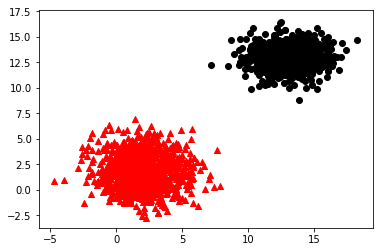

>epoch=0, error=41.183
>epoch=1, error=53.442
>epoch=2, error=51.846
>epoch=3, error=51.730
>epoch=4, error=51.420
>epoch=5, error=50.398
>epoch=6, error=47.286
>epoch=7, error=31.048
>epoch=8, error=0.000
>epoch=9, error=0.000
>epoch=10, error=0.000
>epoch=11, error=0.000
>epoch=12, error=0.000
>epoch=13, error=0.000
>epoch=14, error=0.000
>epoch=15, error=0.000
>epoch=16, error=0.000
>epoch=17, error=0.000
>epoch=18, error=0.000
>epoch=19, error=0.000
>epoch=20, error=0.000
>epoch=21, error=0.000
>epoch=22, error=0.000
>epoch=23, error=0.000
>epoch=24, error=0.000
>epoch=25, error=0.000
>epoch=26, error=0.000
>epoch=27, error=0.000
>epoch=28, error=0.000
>epoch=29, error=0.000
>epoch=30, error=0.000
>epoch=31, error=0.000
>epoch=32, error=0.000
>epoch=33, error=0.000
>epoch=34, error=0.000
>epoch=35, error=0.000
>epoch=36, error=0.000
>epoch=37, error=0.000
>epoch=38, error=0.000
>epoch=39, error=0.000
>epoch=40, error=0.000
>epoch=41, error=0.000
>epoch=42, error=0.000
>epoch=43, er

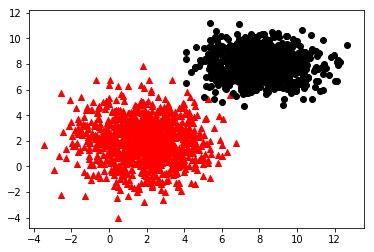

>epoch=0, error=48.744
>epoch=1, error=53.889
>epoch=2, error=50.912
>epoch=3, error=50.239
>epoch=4, error=48.042
>epoch=5, error=13.856
>epoch=6, error=10.954
>epoch=7, error=11.832
>epoch=8, error=4.000
>epoch=9, error=3.464
>epoch=10, error=3.464
>epoch=11, error=3.464
>epoch=12, error=4.000
>epoch=13, error=4.000
>epoch=14, error=3.464
>epoch=15, error=3.464
>epoch=16, error=3.464
>epoch=17, error=4.000
>epoch=18, error=3.464
>epoch=19, error=3.464
>epoch=20, error=3.464
>epoch=21, error=4.000
>epoch=22, error=3.464
>epoch=23, error=3.464
>epoch=24, error=3.464
>epoch=25, error=4.000
>epoch=26, error=3.464
>epoch=27, error=3.464
>epoch=28, error=3.464
>epoch=29, error=3.464
>epoch=30, error=3.464
>epoch=31, error=3.464
>epoch=32, error=4.000
>epoch=33, error=3.464
>epoch=34, error=3.464
>epoch=35, error=3.464
>epoch=36, error=4.000
>epoch=37, error=3.464
>epoch=38, error=3.464
>epoch=39, error=3.464
>epoch=40, error=3.464
>epoch=41, error=3.464
>epoch=42, error=3.464
>epoch=43, er

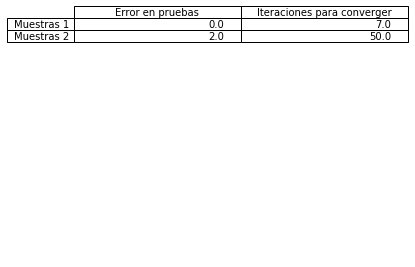

In [11]:
#Exercise 2.3.a Test the Perceptron implementation


def exercise2_3a():
    """
    Perform 2 tests with different separation distances between classes. 
    """
    totalEpochs = 50
    samplesPerClass = 1000
    
    #vector with all experiments' errors 
    vDatosTabla= torch.zeros(2,2)    
    collabel=('Error en pruebas', 'Iteraciones para converger')
    rowlabel=(1,2)
    
    # Sample data 1. Linearly separable
    print("Conjunto de muestras 1")
    (TargetsA, SamplesA) = createData(numberSamplesPerClass = samplesPerClass, mean2 = [13, 13])
    finalErrorA, convergenceEpochA, allErrorA = testPerceptron(SamplesA, TargetsA, epochs = totalEpochs, testSize = 0.3)
    vDatosTabla[0][0] = finalErrorA
    vDatosTabla[0][1] = convergenceEpochA

    # Sample data 2. Linearly separable
    print("Conjunto de muestras 2")
    (TargetsB, SamplesB) = createData(numberSamplesPerClass = samplesPerClass, mean2 = [8, 8])                                
    finalErrorB, convergenceEpochB, allErrorB = testPerceptron(SamplesB, TargetsB, epochs = totalEpochs, testSize = 0.3)
    vDatosTabla[1][0] = finalErrorB    
    vDatosTabla[1][1] = convergenceEpochB
    
    print("============ TABLA: Exercise 2.3.a ================")
    print("------ Número de muestras mal clasificadas -------")
    print("------ Iteraciones = número de épocas => algoritmo no convergió ")
    print("------ Épocas totales: ", totalEpochs)
    print("------ Muestras por clase: ", samplesPerClass)
    print("===================================================")


    plotErrorTable(vDatosTabla, collabel, rowlabel)

    return(allErrorA, allErrorB)

#Exercise 2.3.a
allErrorA, allErrorB = exercise2_3a()

##  Exercise 2.3b Reporte los resultados: 
Promedio y varianza para 10 corridas, con  datos generados con tres distintas circunstancias de separabilidad de los datos: linealmente separables, no linealmente separables con mezcla leve de los datos, y mezcla mayor de los datos.

In [0]:
#Exercise 2.3.b Test the Perceptron implementation

def exercise2_3b(totalEpochs = 5, samplesPerClass = 1000, pmean2=[13, 13], tTitle="Muestras"):
    """
    Perform 10 tests with different separation distances between classes. 
    """
    experiments = 10
    samplesCount = 0
    meanV=pmean2
    
    #vector with all experiments' errors 
    vDatosTabla= torch.zeros(experiments, 2)    
    collabel=('Error', 'Iteraciones para converger')
    rowlabel=(1,2,3,4,5,6,7,8,9,10)

    
    for samplesCount in range(experiments):
    
        # Sample data 
        print("Conjunto de muestras ", samplesCount)
        (TargetsA, SamplesA) = createData(numberSamplesPerClass = samplesPerClass, mean2 = meanV)
        finalErrorA, convergenceEpochA, allError = testPerceptron(SamplesA, TargetsA, epochs = totalEpochs, testSize = 0.3)
        vDatosTabla[samplesCount-1][0] = finalErrorA
        vDatosTabla[samplesCount-1][1] = convergenceEpochA
        samplesCount = samplesCount + 1
        meanV[0] = meanV[0]+samplesCount * 0.1
        meanV[1] = meanV[1]+samplesCount * 0.1

        
    #Statistics 
    
    
    print("================== TABLA: Exercise 2.3.b =====================")
    print("--", tTitle)
    print("------ Resultados, promedio y varianza")
    print("------ Iteraciones = numero de épocas=> algoritmo no convergió ")
    print("------ Épocas totales: ", totalEpochs)
    print("------ Muestras por clase: ", samplesPerClass)
    print("------ Cantidad de experimentos: ", experiments)    
    print("-------Error medio: ", torch.mean(vDatosTabla[:,0]))
    print("-------Promedio de iteraciones para converger: ", torch.mean(vDatosTabla[:,1]))
    print("-------Desviación estandar del error: ", torch.std(vDatosTabla[:,0]))
    print("-------Desviación estandar de la iteraciones para converger: ", torch.std(vDatosTabla[:,1]))

    print("===================================================")

    plotErrorTable(vDatosTabla, collabel, rowlabel)
    
    return


Conjunto de muestras  0


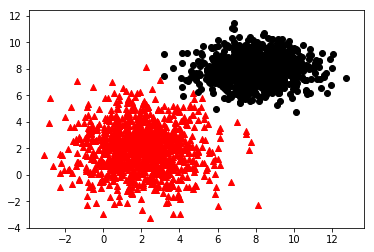

>epoch=0, error=53.329
>epoch=1, error=51.846
>epoch=2, error=51.730
>epoch=3, error=51.186
>epoch=4, error=47.582
>epoch=5, error=52.726
>epoch=6, error=51.303
>epoch=7, error=50.438
>epoch=8, error=48.208
>epoch=9, error=32.924
>epoch=10, error=29.866
>epoch=11, error=42.942
>epoch=12, error=8.944
>epoch=13, error=5.292
>epoch=14, error=4.472
>epoch=15, error=5.292
>epoch=16, error=5.292
>epoch=17, error=4.472
>epoch=18, error=5.292
>epoch=19, error=4.472
>epoch=20, error=4.899
>epoch=21, error=3.464
>epoch=22, error=4.000
>epoch=23, error=3.464
>epoch=24, error=3.464
>epoch=25, error=4.000
>epoch=26, error=3.464
>epoch=27, error=4.000
>epoch=28, error=3.464
>epoch=29, error=3.464
>epoch=30, error=4.000
>epoch=31, error=3.464
>epoch=32, error=3.464
>epoch=33, error=3.464
>epoch=34, error=2.828
>epoch=35, error=3.464
>epoch=36, error=2.828
>epoch=37, error=3.464
>epoch=38, error=2.828
>epoch=39, error=3.464
Error total para el conjunto de muestras: tensor(4.)
Conjunto de muestras  1


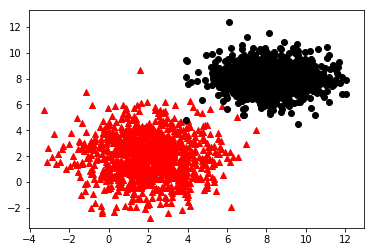

>epoch=0, error=43.174
>epoch=1, error=53.740
>epoch=2, error=51.381
>epoch=3, error=51.029
>epoch=4, error=49.315
>epoch=5, error=21.541
>epoch=6, error=53.066
>epoch=7, error=50.754
>epoch=8, error=50.120
>epoch=9, error=48.456
>epoch=10, error=41.231
>epoch=11, error=4.000
>epoch=12, error=4.000
>epoch=13, error=4.000
>epoch=14, error=4.000
>epoch=15, error=3.464
>epoch=16, error=3.464
>epoch=17, error=3.464
>epoch=18, error=3.464
>epoch=19, error=2.828
>epoch=20, error=2.828
>epoch=21, error=2.828
>epoch=22, error=2.828
>epoch=23, error=2.828
>epoch=24, error=2.000
>epoch=25, error=2.828
>epoch=26, error=2.828
>epoch=27, error=2.828
>epoch=28, error=2.000
>epoch=29, error=2.828
>epoch=30, error=2.828
>epoch=31, error=2.828
>epoch=32, error=2.000
>epoch=33, error=2.828
>epoch=34, error=2.828
>epoch=35, error=2.828
>epoch=36, error=2.000
>epoch=37, error=2.828
>epoch=38, error=2.828
>epoch=39, error=2.828
Error total para el conjunto de muestras: tensor(2.)
Conjunto de muestras  2


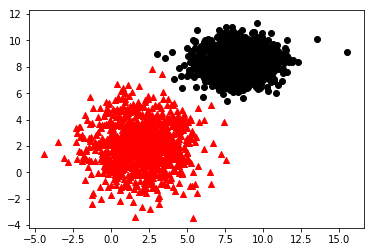

>epoch=0, error=53.740
>epoch=1, error=51.614
>epoch=2, error=51.459
>epoch=3, error=50.794
>epoch=4, error=48.456
>epoch=5, error=24.166
>epoch=6, error=44.811
>epoch=7, error=53.254
>epoch=8, error=50.675
>epoch=9, error=49.639
>epoch=10, error=47.539
>epoch=11, error=38.053
>epoch=12, error=3.464
>epoch=13, error=2.828
>epoch=14, error=2.000
>epoch=15, error=2.828
>epoch=16, error=2.828
>epoch=17, error=2.828
>epoch=18, error=2.828
>epoch=19, error=2.000
>epoch=20, error=2.828
>epoch=21, error=2.828
>epoch=22, error=2.828
>epoch=23, error=2.828
>epoch=24, error=2.828
>epoch=25, error=2.828
>epoch=26, error=2.828
>epoch=27, error=2.828
>epoch=28, error=2.828
>epoch=29, error=2.828
>epoch=30, error=2.828
>epoch=31, error=2.000
>epoch=32, error=2.828
>epoch=33, error=2.828
>epoch=34, error=2.828
>epoch=35, error=2.828
>epoch=36, error=2.828
>epoch=37, error=2.828
>epoch=38, error=2.828
>epoch=39, error=2.828
Error total para el conjunto de muestras: tensor(2.)
Conjunto de muestras  3


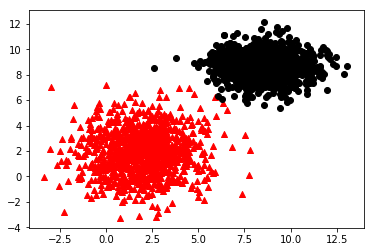

>epoch=0, error=57.026
>epoch=1, error=50.794
>epoch=2, error=50.557
>epoch=3, error=50.080
>epoch=4, error=48.456
>epoch=5, error=33.586
>epoch=6, error=53.666
>epoch=7, error=49.920
>epoch=8, error=49.153
>epoch=9, error=47.917
>epoch=10, error=42.379
>epoch=11, error=16.248
>epoch=12, error=6.325
>epoch=13, error=5.292
>epoch=14, error=4.472
>epoch=15, error=4.000
>epoch=16, error=3.464
>epoch=17, error=3.464
>epoch=18, error=3.464
>epoch=19, error=3.464
>epoch=20, error=3.464
>epoch=21, error=2.828
>epoch=22, error=2.828
>epoch=23, error=2.000
>epoch=24, error=3.464
>epoch=25, error=2.000
>epoch=26, error=3.464
>epoch=27, error=2.000
>epoch=28, error=3.464
>epoch=29, error=2.000
>epoch=30, error=3.464
>epoch=31, error=2.000
>epoch=32, error=2.828
>epoch=33, error=2.828
>epoch=34, error=2.828
>epoch=35, error=2.000
>epoch=36, error=3.464
>epoch=37, error=2.000
>epoch=38, error=3.464
>epoch=39, error=2.000
Error total para el conjunto de muestras: tensor(0.)
Conjunto de muestras  4


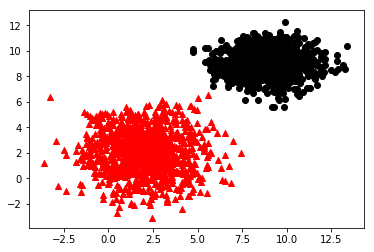

>epoch=0, error=55.714
>epoch=1, error=52.154
>epoch=2, error=51.884
>epoch=3, error=51.225
>epoch=4, error=49.193
>epoch=5, error=9.798
>epoch=6, error=2.000
>epoch=7, error=0.000
>epoch=8, error=0.000
>epoch=9, error=0.000
>epoch=10, error=0.000
>epoch=11, error=0.000
>epoch=12, error=0.000
>epoch=13, error=0.000
>epoch=14, error=0.000
>epoch=15, error=0.000
>epoch=16, error=0.000
>epoch=17, error=0.000
>epoch=18, error=0.000
>epoch=19, error=0.000
>epoch=20, error=0.000
>epoch=21, error=0.000
>epoch=22, error=0.000
>epoch=23, error=0.000
>epoch=24, error=0.000
>epoch=25, error=0.000
>epoch=26, error=0.000
>epoch=27, error=0.000
>epoch=28, error=0.000
>epoch=29, error=0.000
>epoch=30, error=0.000
>epoch=31, error=0.000
>epoch=32, error=0.000
>epoch=33, error=0.000
>epoch=34, error=0.000
>epoch=35, error=0.000
>epoch=36, error=0.000
>epoch=37, error=0.000
>epoch=38, error=0.000
>epoch=39, error=0.000
Error total para el conjunto de muestras: tensor(2.)
Conjunto de muestras  5


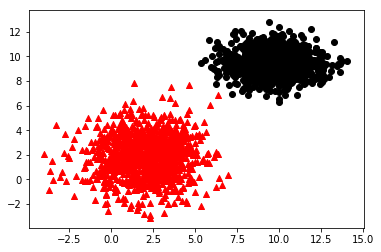

>epoch=0, error=47.159
>epoch=1, error=54.074
>epoch=2, error=50.754
>epoch=3, error=50.517
>epoch=4, error=49.759
>epoch=5, error=45.299
>epoch=6, error=43.543
>epoch=7, error=49.960
>epoch=8, error=47.917
>epoch=9, error=41.280
>epoch=10, error=4.899
>epoch=11, error=4.000
>epoch=12, error=3.464
>epoch=13, error=3.464
>epoch=14, error=3.464
>epoch=15, error=2.828
>epoch=16, error=2.828
>epoch=17, error=2.828
>epoch=18, error=2.000
>epoch=19, error=2.000
>epoch=20, error=2.000
>epoch=21, error=0.000
>epoch=22, error=0.000
>epoch=23, error=0.000
>epoch=24, error=0.000
>epoch=25, error=0.000
>epoch=26, error=0.000
>epoch=27, error=0.000
>epoch=28, error=0.000
>epoch=29, error=0.000
>epoch=30, error=0.000
>epoch=31, error=0.000
>epoch=32, error=0.000
>epoch=33, error=0.000
>epoch=34, error=0.000
>epoch=35, error=0.000
>epoch=36, error=0.000
>epoch=37, error=0.000
>epoch=38, error=0.000
>epoch=39, error=0.000
Error total para el conjunto de muestras: tensor(0.)
Conjunto de muestras  6


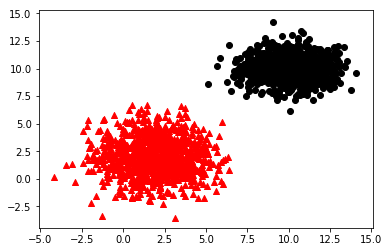

>epoch=0, error=53.066
>epoch=1, error=52.115
>epoch=2, error=51.962
>epoch=3, error=51.303
>epoch=4, error=50.120
>epoch=5, error=42.661
>epoch=6, error=52.612
>epoch=7, error=51.108
>epoch=8, error=50.438
>epoch=9, error=49.071
>epoch=10, error=44.721
>epoch=11, error=22.091
>epoch=12, error=2.000
>epoch=13, error=2.000
>epoch=14, error=2.000
>epoch=15, error=2.000
>epoch=16, error=2.000
>epoch=17, error=2.000
>epoch=18, error=2.000
>epoch=19, error=2.000
>epoch=20, error=0.000
>epoch=21, error=0.000
>epoch=22, error=0.000
>epoch=23, error=0.000
>epoch=24, error=0.000
>epoch=25, error=0.000
>epoch=26, error=0.000
>epoch=27, error=0.000
>epoch=28, error=0.000
>epoch=29, error=0.000
>epoch=30, error=0.000
>epoch=31, error=0.000
>epoch=32, error=0.000
>epoch=33, error=0.000
>epoch=34, error=0.000
>epoch=35, error=0.000
>epoch=36, error=0.000
>epoch=37, error=0.000
>epoch=38, error=0.000
>epoch=39, error=0.000
Error total para el conjunto de muestras: tensor(2.)
Conjunto de muestras  7


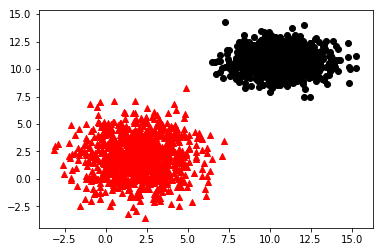

>epoch=0, error=32.863
>epoch=1, error=54.663
>epoch=2, error=51.884
>epoch=3, error=51.691
>epoch=4, error=51.225
>epoch=5, error=49.800
>epoch=6, error=41.952
>epoch=7, error=52.839
>epoch=8, error=51.069
>epoch=9, error=50.438
>epoch=10, error=49.193
>epoch=11, error=46.519
>epoch=12, error=35.496
>epoch=13, error=8.485
>epoch=14, error=4.899
>epoch=15, error=4.472
>epoch=16, error=3.464
>epoch=17, error=3.464
>epoch=18, error=2.828
>epoch=19, error=2.828
>epoch=20, error=2.828
>epoch=21, error=2.000
>epoch=22, error=2.000
>epoch=23, error=2.000
>epoch=24, error=2.000
>epoch=25, error=2.000
>epoch=26, error=2.000
>epoch=27, error=2.000
>epoch=28, error=2.000
>epoch=29, error=2.000
>epoch=30, error=2.000
>epoch=31, error=2.000
>epoch=32, error=2.000
>epoch=33, error=2.000
>epoch=34, error=2.000
>epoch=35, error=2.000
>epoch=36, error=2.000
>epoch=37, error=2.000
>epoch=38, error=2.000
>epoch=39, error=0.000
Error total para el conjunto de muestras: tensor(0.)
Conjunto de muestras  8


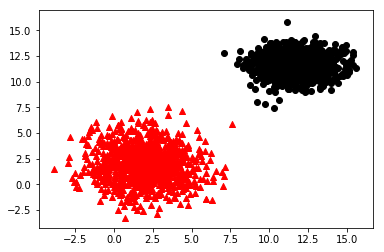

>epoch=0, error=55.929
>epoch=1, error=51.108
>epoch=2, error=50.872
>epoch=3, error=50.596
>epoch=4, error=50.080
>epoch=5, error=48.785
>epoch=6, error=39.243
>epoch=7, error=27.423
>epoch=8, error=45.651
>epoch=9, error=18.655
>epoch=10, error=2.000
>epoch=11, error=0.000
>epoch=12, error=0.000
>epoch=13, error=0.000
>epoch=14, error=0.000
>epoch=15, error=0.000
>epoch=16, error=0.000
>epoch=17, error=0.000
>epoch=18, error=0.000
>epoch=19, error=0.000
>epoch=20, error=0.000
>epoch=21, error=0.000
>epoch=22, error=0.000
>epoch=23, error=0.000
>epoch=24, error=0.000
>epoch=25, error=0.000
>epoch=26, error=0.000
>epoch=27, error=0.000
>epoch=28, error=0.000
>epoch=29, error=0.000
>epoch=30, error=0.000
>epoch=31, error=0.000
>epoch=32, error=0.000
>epoch=33, error=0.000
>epoch=34, error=0.000
>epoch=35, error=0.000
>epoch=36, error=0.000
>epoch=37, error=0.000
>epoch=38, error=0.000
>epoch=39, error=0.000
Error total para el conjunto de muestras: tensor(2.8284)
Conjunto de muestras  9

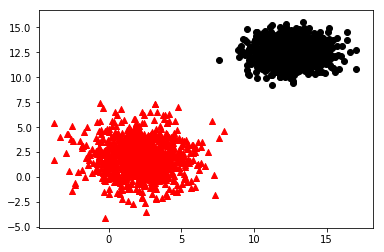

>epoch=0, error=55.678
>epoch=1, error=52.115
>epoch=2, error=52.115
>epoch=3, error=51.730
>epoch=4, error=50.951
>epoch=5, error=49.518
>epoch=6, error=38.781
>epoch=7, error=4.000
>epoch=8, error=0.000
>epoch=9, error=0.000
>epoch=10, error=0.000
>epoch=11, error=0.000
>epoch=12, error=0.000
>epoch=13, error=0.000
>epoch=14, error=0.000
>epoch=15, error=0.000
>epoch=16, error=0.000
>epoch=17, error=0.000
>epoch=18, error=0.000
>epoch=19, error=0.000
>epoch=20, error=0.000
>epoch=21, error=0.000
>epoch=22, error=0.000
>epoch=23, error=0.000
>epoch=24, error=0.000
>epoch=25, error=0.000
>epoch=26, error=0.000
>epoch=27, error=0.000
>epoch=28, error=0.000
>epoch=29, error=0.000
>epoch=30, error=0.000
>epoch=31, error=0.000
>epoch=32, error=0.000
>epoch=33, error=0.000
>epoch=34, error=0.000
>epoch=35, error=0.000
>epoch=36, error=0.000
>epoch=37, error=0.000
>epoch=38, error=0.000
>epoch=39, error=0.000
Error total para el conjunto de muestras: tensor(0.)
================== TABLA: Exer

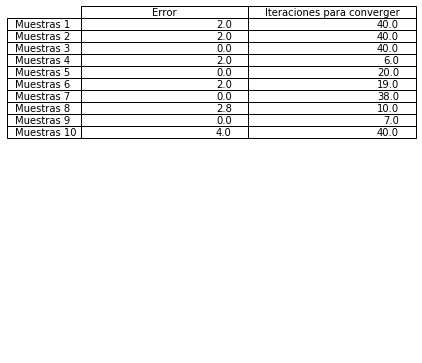

In [6]:
#Exercise 2.3.b

#linearly separable data 
exercise2_3b(totalEpochs = 40, samplesPerClass = 1000, pmean2=[8, 8], tTitle="Datos linealmente separables")

Conjunto de muestras  0


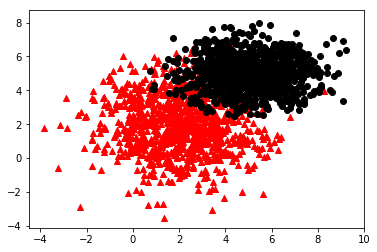

>epoch=0, error=46.000
>epoch=1, error=52.839
>epoch=2, error=52.536
>epoch=3, error=50.319
>epoch=4, error=52.154
>epoch=5, error=52.307
>epoch=6, error=49.437
>epoch=7, error=52.154
>epoch=8, error=51.807
>epoch=9, error=48.949
>epoch=10, error=20.199
>epoch=11, error=43.128
>epoch=12, error=49.193
>epoch=13, error=32.680
>epoch=14, error=52.154
>epoch=15, error=50.239
>epoch=16, error=46.303
>epoch=17, error=19.183
>epoch=18, error=23.324
>epoch=19, error=25.298
>epoch=20, error=45.869
>epoch=21, error=48.456
>epoch=22, error=35.665
>epoch=23, error=44.452
>epoch=24, error=47.117
>epoch=25, error=30.854
>epoch=26, error=40.050
>epoch=27, error=43.818
>epoch=28, error=20.298
>epoch=29, error=24.166
>epoch=30, error=24.166
>epoch=31, error=30.659
>epoch=32, error=33.466
>epoch=33, error=32.496
>epoch=34, error=35.270
>epoch=35, error=27.785
>epoch=36, error=28.983
>epoch=37, error=33.526
>epoch=38, error=36.056
>epoch=39, error=24.658
Error total para el conjunto de muestras: tensor(1

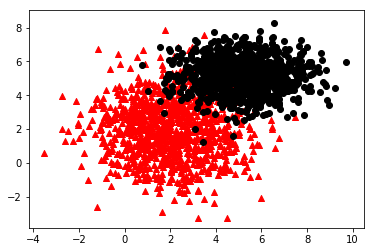

>epoch=0, error=54.222
>epoch=1, error=52.536
>epoch=2, error=52.038
>epoch=3, error=45.387
>epoch=4, error=52.764
>epoch=5, error=51.459
>epoch=6, error=48.662
>epoch=7, error=52.726
>epoch=8, error=51.108
>epoch=9, error=48.908
>epoch=10, error=29.665
>epoch=11, error=52.726
>epoch=12, error=50.160
>epoch=13, error=46.690
>epoch=14, error=23.917
>epoch=15, error=48.621
>epoch=16, error=48.826
>epoch=17, error=42.568
>epoch=18, error=22.716
>epoch=19, error=23.065
>epoch=20, error=39.395
>epoch=21, error=44.407
>epoch=22, error=21.633
>epoch=23, error=34.525
>epoch=24, error=40.050
>epoch=25, error=23.409
>epoch=26, error=23.580
>epoch=27, error=36.332
>epoch=28, error=41.085
>epoch=29, error=19.391
>epoch=30, error=19.799
>epoch=31, error=18.655
>epoch=32, error=20.494
>epoch=33, error=19.079
>epoch=34, error=23.238
>epoch=35, error=23.238
>epoch=36, error=34.059
>epoch=37, error=38.523
>epoch=38, error=22.804
>epoch=39, error=22.271
Error total para el conjunto de muestras: tensor(2

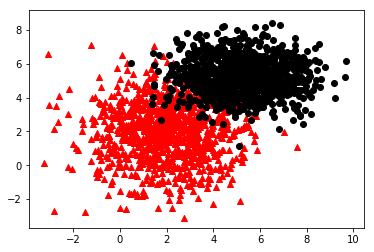

>epoch=0, error=53.028
>epoch=1, error=52.383
>epoch=2, error=52.000
>epoch=3, error=47.582
>epoch=4, error=52.345
>epoch=5, error=51.575
>epoch=6, error=48.744
>epoch=7, error=52.345
>epoch=8, error=51.147
>epoch=9, error=49.031
>epoch=10, error=20.396
>epoch=11, error=36.661
>epoch=12, error=47.286
>epoch=13, error=32.187
>epoch=14, error=43.359
>epoch=15, error=52.345
>epoch=16, error=50.239
>epoch=17, error=46.776
>epoch=18, error=23.580
>epoch=19, error=45.913
>epoch=20, error=48.415
>epoch=21, error=37.310
>epoch=22, error=43.359
>epoch=23, error=46.648
>epoch=24, error=30.984
>epoch=25, error=43.772
>epoch=26, error=46.217
>epoch=27, error=30.984
>epoch=28, error=36.824
>epoch=29, error=40.150
>epoch=30, error=20.100
>epoch=31, error=21.166
>epoch=32, error=20.100
>epoch=33, error=26.153
>epoch=34, error=28.213
>epoch=35, error=36.332
>epoch=36, error=39.446
>epoch=37, error=20.100
>epoch=38, error=20.591
>epoch=39, error=19.391
Error total para el conjunto de muestras: tensor(1

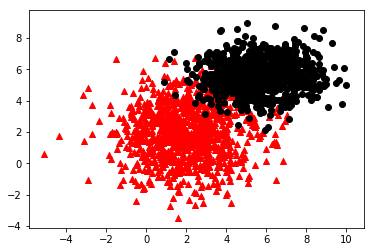

>epoch=0, error=66.061
>epoch=1, error=51.807
>epoch=2, error=46.861
>epoch=3, error=52.536
>epoch=4, error=51.498
>epoch=5, error=49.031
>epoch=6, error=39.547
>epoch=7, error=49.558
>epoch=8, error=29.530
>epoch=9, error=52.498
>epoch=10, error=50.715
>epoch=11, error=47.666
>epoch=12, error=27.423
>epoch=13, error=52.498
>epoch=14, error=50.160
>epoch=15, error=46.947
>epoch=16, error=30.332
>epoch=17, error=48.208
>epoch=18, error=48.125
>epoch=19, error=42.190
>epoch=20, error=15.232
>epoch=21, error=19.079
>epoch=22, error=17.776
>epoch=23, error=26.230
>epoch=24, error=30.000
>epoch=25, error=37.041
>epoch=26, error=42.661
>epoch=27, error=17.205
>epoch=28, error=23.495
>epoch=29, error=24.413
>epoch=30, error=30.463
>epoch=31, error=34.814
>epoch=32, error=23.324
>epoch=33, error=23.749
>epoch=34, error=28.425
>epoch=35, error=31.623
>epoch=36, error=25.923
>epoch=37, error=27.495
>epoch=38, error=26.683
>epoch=39, error=28.566
Error total para el conjunto de muestras: tensor(1

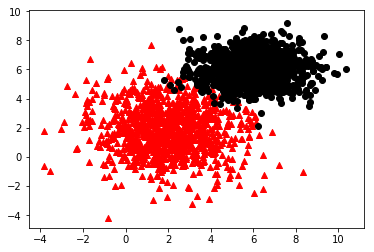

>epoch=0, error=57.827
>epoch=1, error=51.303
>epoch=2, error=50.557
>epoch=3, error=50.438
>epoch=4, error=51.108
>epoch=5, error=49.719
>epoch=6, error=40.398
>epoch=7, error=53.554
>epoch=8, error=50.319
>epoch=9, error=48.580
>epoch=10, error=39.497
>epoch=11, error=47.791
>epoch=12, error=48.785
>epoch=13, error=44.227
>epoch=14, error=21.633
>epoch=15, error=19.183
>epoch=16, error=20.396
>epoch=17, error=17.550
>epoch=18, error=17.321
>epoch=19, error=14.000
>epoch=20, error=13.565
>epoch=21, error=12.166
>epoch=22, error=12.329
>epoch=23, error=12.166
>epoch=24, error=12.329
>epoch=25, error=12.000
>epoch=26, error=12.329
>epoch=27, error=12.329
>epoch=28, error=12.329
>epoch=29, error=11.489
>epoch=30, error=12.000
>epoch=31, error=12.806
>epoch=32, error=12.329
>epoch=33, error=12.329
>epoch=34, error=12.329
>epoch=35, error=11.489
>epoch=36, error=12.000
>epoch=37, error=12.490
>epoch=38, error=12.329
>epoch=39, error=12.329
Error total para el conjunto de muestras: tensor(6

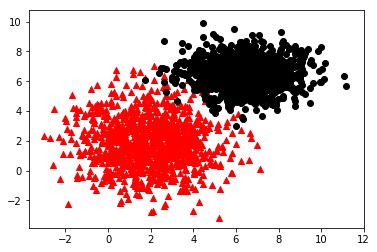

>epoch=0, error=58.856
>epoch=1, error=51.575
>epoch=2, error=51.108
>epoch=3, error=49.234
>epoch=4, error=53.292
>epoch=5, error=50.951
>epoch=6, error=49.920
>epoch=7, error=46.690
>epoch=8, error=18.221
>epoch=9, error=28.705
>epoch=10, error=40.792
>epoch=11, error=30.790
>epoch=12, error=41.665
>epoch=13, error=8.246
>epoch=14, error=7.746
>epoch=15, error=7.746
>epoch=16, error=7.746
>epoch=17, error=7.746
>epoch=18, error=7.746
>epoch=19, error=7.746
>epoch=20, error=7.746
>epoch=21, error=7.746
>epoch=22, error=8.000
>epoch=23, error=7.746
>epoch=24, error=7.746
>epoch=25, error=7.746
>epoch=26, error=7.746
>epoch=27, error=7.746
>epoch=28, error=7.746
>epoch=29, error=7.746
>epoch=30, error=7.746
>epoch=31, error=7.746
>epoch=32, error=7.746
>epoch=33, error=7.746
>epoch=34, error=7.746
>epoch=35, error=7.746
>epoch=36, error=7.746
>epoch=37, error=7.746
>epoch=38, error=7.746
>epoch=39, error=7.746
Error total para el conjunto de muestras: tensor(6.)
Conjunto de muestras  6


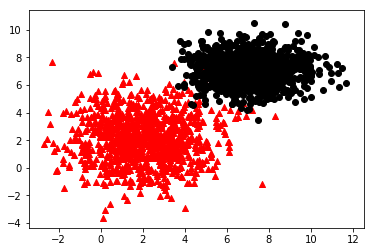

>epoch=0, error=47.202
>epoch=1, error=53.028
>epoch=2, error=52.383
>epoch=3, error=51.730
>epoch=4, error=49.275
>epoch=5, error=52.307
>epoch=6, error=51.653
>epoch=7, error=50.675
>epoch=8, error=45.651
>epoch=9, error=52.307
>epoch=10, error=51.029
>epoch=11, error=49.800
>epoch=12, error=43.451
>epoch=13, error=8.485
>epoch=14, error=8.485
>epoch=15, error=8.485
>epoch=16, error=8.718
>epoch=17, error=8.485
>epoch=18, error=8.944
>epoch=19, error=8.246
>epoch=20, error=8.485
>epoch=21, error=8.246
>epoch=22, error=7.746
>epoch=23, error=7.746
>epoch=24, error=7.746
>epoch=25, error=7.746
>epoch=26, error=7.746
>epoch=27, error=7.746
>epoch=28, error=7.746
>epoch=29, error=7.746
>epoch=30, error=7.746
>epoch=31, error=7.746
>epoch=32, error=7.746
>epoch=33, error=8.000
>epoch=34, error=7.746
>epoch=35, error=7.746
>epoch=36, error=7.746
>epoch=37, error=7.746
>epoch=38, error=7.746
>epoch=39, error=7.746
Error total para el conjunto de muestras: tensor(3.4641)
Conjunto de muestras

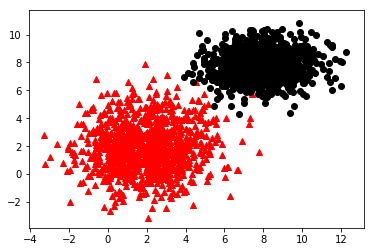

>epoch=0, error=52.991
>epoch=1, error=53.367
>epoch=2, error=51.575
>epoch=3, error=50.675
>epoch=4, error=46.989
>epoch=5, error=52.839
>epoch=6, error=50.715
>epoch=7, error=49.840
>epoch=8, error=47.749
>epoch=9, error=31.048
>epoch=10, error=33.645
>epoch=11, error=45.299
>epoch=12, error=22.891
>epoch=13, error=5.657
>epoch=14, error=4.472
>epoch=15, error=4.899
>epoch=16, error=4.472
>epoch=17, error=4.899
>epoch=18, error=4.899
>epoch=19, error=4.899
>epoch=20, error=4.472
>epoch=21, error=4.899
>epoch=22, error=4.899
>epoch=23, error=4.899
>epoch=24, error=4.472
>epoch=25, error=4.899
>epoch=26, error=4.899
>epoch=27, error=4.472
>epoch=28, error=4.472
>epoch=29, error=4.472
>epoch=30, error=4.899
>epoch=31, error=4.472
>epoch=32, error=4.899
>epoch=33, error=4.899
>epoch=34, error=4.472
>epoch=35, error=4.472
>epoch=36, error=4.472
>epoch=37, error=4.899
>epoch=38, error=4.472
>epoch=39, error=4.472
Error total para el conjunto de muestras: tensor(4.)
Conjunto de muestras  8


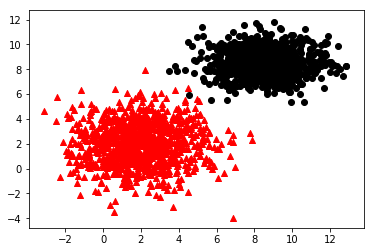

>epoch=0, error=61.514
>epoch=1, error=52.154
>epoch=2, error=51.614
>epoch=3, error=49.193
>epoch=4, error=25.298
>epoch=5, error=46.347
>epoch=6, error=52.421
>epoch=7, error=51.381
>epoch=8, error=50.557
>epoch=9, error=48.249
>epoch=10, error=36.497
>epoch=11, error=4.899
>epoch=12, error=3.464
>epoch=13, error=2.828
>epoch=14, error=2.828
>epoch=15, error=2.828
>epoch=16, error=2.828
>epoch=17, error=2.828
>epoch=18, error=2.828
>epoch=19, error=2.000
>epoch=20, error=2.828
>epoch=21, error=2.828
>epoch=22, error=2.828
>epoch=23, error=2.000
>epoch=24, error=2.828
>epoch=25, error=2.828
>epoch=26, error=2.828
>epoch=27, error=2.000
>epoch=28, error=2.828
>epoch=29, error=2.828
>epoch=30, error=2.828
>epoch=31, error=2.828
>epoch=32, error=2.000
>epoch=33, error=2.828
>epoch=34, error=3.464
>epoch=35, error=2.000
>epoch=36, error=3.464
>epoch=37, error=2.000
>epoch=38, error=2.828
>epoch=39, error=2.828
Error total para el conjunto de muestras: tensor(0.)
Conjunto de muestras  9


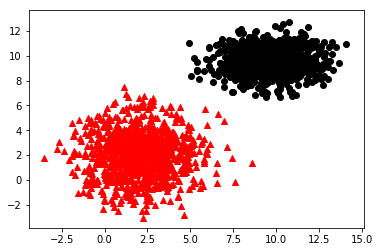

>epoch=0, error=56.533
>epoch=1, error=51.575
>epoch=2, error=51.381
>epoch=3, error=50.833
>epoch=4, error=49.558
>epoch=5, error=37.630
>epoch=6, error=53.141
>epoch=7, error=50.675
>epoch=8, error=50.120
>epoch=9, error=48.703
>epoch=10, error=44.542
>epoch=11, error=17.436
>epoch=12, error=4.000
>epoch=13, error=4.000
>epoch=14, error=3.464
>epoch=15, error=3.464
>epoch=16, error=3.464
>epoch=17, error=2.828
>epoch=18, error=2.828
>epoch=19, error=0.000
>epoch=20, error=0.000
>epoch=21, error=0.000
>epoch=22, error=0.000
>epoch=23, error=0.000
>epoch=24, error=0.000
>epoch=25, error=0.000
>epoch=26, error=0.000
>epoch=27, error=0.000
>epoch=28, error=0.000
>epoch=29, error=0.000
>epoch=30, error=0.000
>epoch=31, error=0.000
>epoch=32, error=0.000
>epoch=33, error=0.000
>epoch=34, error=0.000
>epoch=35, error=0.000
>epoch=36, error=0.000
>epoch=37, error=0.000
>epoch=38, error=0.000
>epoch=39, error=0.000
Error total para el conjunto de muestras: tensor(0.)
================== TABLA:

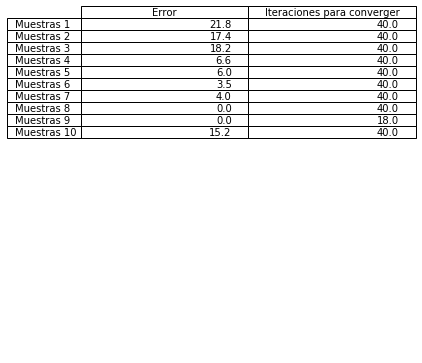

In [13]:
#Exercise 2.3.b

#Test with non-linearly separable data with slight data blending
exercise2_3b(totalEpochs = 40, samplesPerClass = 1000, pmean2=[5, 5], tTitle="Datos no linealmente separables con mezcla leve")

Conjunto de muestras  0


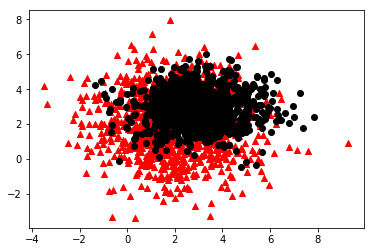

>epoch=0, error=48.497
>epoch=1, error=53.666
>epoch=2, error=51.691
>epoch=3, error=53.367
>epoch=4, error=51.691
>epoch=5, error=53.141
>epoch=6, error=51.730
>epoch=7, error=48.785
>epoch=8, error=53.104
>epoch=9, error=50.596
>epoch=10, error=53.066
>epoch=11, error=51.108
>epoch=12, error=43.863
>epoch=13, error=53.066
>epoch=14, error=50.120
>epoch=15, error=53.066
>epoch=16, error=50.675
>epoch=17, error=44.000
>epoch=18, error=53.066
>epoch=19, error=49.639
>epoch=20, error=53.066
>epoch=21, error=50.279
>epoch=22, error=44.272
>epoch=23, error=53.066
>epoch=24, error=49.234
>epoch=25, error=52.536
>epoch=26, error=49.920
>epoch=27, error=42.755
>epoch=28, error=53.066
>epoch=29, error=49.193
>epoch=30, error=47.497
>epoch=31, error=46.390
>epoch=32, error=53.066
>epoch=33, error=49.153
>epoch=34, error=46.303
>epoch=35, error=44.855
>epoch=36, error=53.066
>epoch=37, error=48.990
>epoch=38, error=50.596
>epoch=39, error=48.456
Error total para el conjunto de muestras: tensor(3

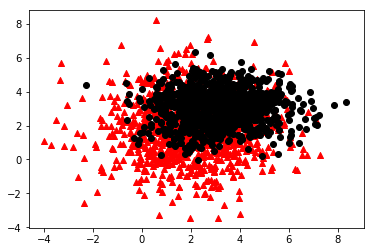

>epoch=0, error=57.061
>epoch=1, error=51.381
>epoch=2, error=50.438
>epoch=3, error=53.666
>epoch=4, error=50.833
>epoch=5, error=38.626
>epoch=6, error=53.367
>epoch=7, error=50.596
>epoch=8, error=43.174
>epoch=9, error=53.367
>epoch=10, error=50.120
>epoch=11, error=49.598
>epoch=12, error=49.960
>epoch=13, error=38.987
>epoch=14, error=53.367
>epoch=15, error=50.239
>epoch=16, error=44.989
>epoch=17, error=53.367
>epoch=18, error=49.153
>epoch=19, error=39.749
>epoch=20, error=53.442
>epoch=21, error=49.840
>epoch=22, error=44.721
>epoch=23, error=53.367
>epoch=24, error=48.867
>epoch=25, error=39.547
>epoch=26, error=53.367
>epoch=27, error=48.867
>epoch=28, error=41.376
>epoch=29, error=53.367
>epoch=30, error=48.539
>epoch=31, error=40.299
>epoch=32, error=53.367
>epoch=33, error=48.539
>epoch=34, error=40.890
>epoch=35, error=53.367
>epoch=36, error=48.208
>epoch=37, error=40.497
>epoch=38, error=53.367
>epoch=39, error=48.000
Error total para el conjunto de muestras: tensor(2

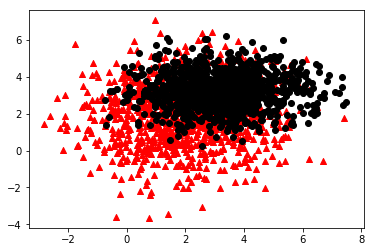

>epoch=0, error=46.260
>epoch=1, error=54.259
>epoch=2, error=51.069
>epoch=3, error=53.479
>epoch=4, error=50.912
>epoch=5, error=48.374
>epoch=6, error=53.479
>epoch=7, error=50.239
>epoch=8, error=48.291
>epoch=9, error=49.920
>epoch=10, error=50.478
>epoch=11, error=50.080
>epoch=12, error=39.850
>epoch=13, error=53.442
>epoch=14, error=49.639
>epoch=15, error=38.053
>epoch=16, error=53.442
>epoch=17, error=49.679
>epoch=18, error=41.761
>epoch=19, error=53.442
>epoch=20, error=48.908
>epoch=21, error=38.158
>epoch=22, error=53.442
>epoch=23, error=49.437
>epoch=24, error=43.035
>epoch=25, error=53.442
>epoch=26, error=48.497
>epoch=27, error=38.262
>epoch=28, error=53.442
>epoch=29, error=48.497
>epoch=30, error=41.376
>epoch=31, error=53.442
>epoch=32, error=48.125
>epoch=33, error=38.730
>epoch=34, error=53.442
>epoch=35, error=48.125
>epoch=36, error=40.645
>epoch=37, error=53.442
>epoch=38, error=47.917
>epoch=39, error=39.446
Error total para el conjunto de muestras: tensor(3

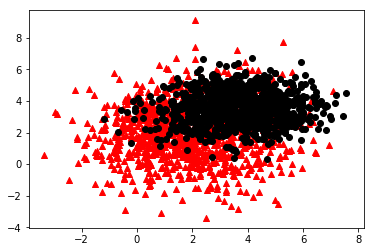

>epoch=0, error=49.880
>epoch=1, error=53.591
>epoch=2, error=51.459
>epoch=3, error=52.877
>epoch=4, error=51.420
>epoch=5, error=48.785
>epoch=6, error=52.877
>epoch=7, error=50.636
>epoch=8, error=39.294
>epoch=9, error=52.877
>epoch=10, error=50.359
>epoch=11, error=39.850
>epoch=12, error=52.877
>epoch=13, error=50.000
>epoch=14, error=38.626
>epoch=15, error=52.877
>epoch=16, error=49.759
>epoch=17, error=39.547
>epoch=18, error=52.877
>epoch=19, error=49.437
>epoch=20, error=38.833
>epoch=21, error=52.877
>epoch=22, error=49.193
>epoch=23, error=39.598
>epoch=24, error=52.877
>epoch=25, error=48.826
>epoch=26, error=39.192
>epoch=27, error=52.877
>epoch=28, error=48.580
>epoch=29, error=39.699
>epoch=30, error=52.877
>epoch=31, error=48.208
>epoch=32, error=39.598
>epoch=33, error=52.383
>epoch=34, error=47.707
>epoch=35, error=38.471
>epoch=36, error=51.614
>epoch=37, error=47.371
>epoch=38, error=37.148
>epoch=39, error=51.575
Error total para el conjunto de muestras: tensor(3

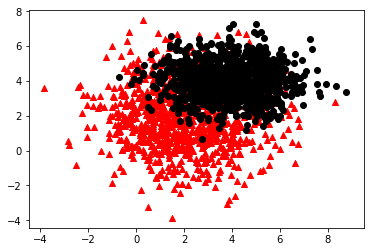

>epoch=0, error=46.000
>epoch=1, error=54.259
>epoch=2, error=51.303
>epoch=3, error=47.202
>epoch=4, error=53.777
>epoch=5, error=50.715
>epoch=6, error=44.045
>epoch=7, error=53.591
>epoch=8, error=50.279
>epoch=9, error=42.988
>epoch=10, error=53.591
>epoch=11, error=49.960
>epoch=12, error=43.220
>epoch=13, error=53.591
>epoch=14, error=49.558
>epoch=15, error=43.267
>epoch=16, error=53.591
>epoch=17, error=49.193
>epoch=18, error=43.451
>epoch=19, error=52.839
>epoch=20, error=48.621
>epoch=21, error=42.661
>epoch=22, error=48.703
>epoch=23, error=46.562
>epoch=24, error=34.293
>epoch=25, error=53.292
>epoch=26, error=47.539
>epoch=27, error=40.890
>epoch=28, error=42.237
>epoch=29, error=40.890
>epoch=30, error=40.694
>epoch=31, error=39.038
>epoch=32, error=44.317
>epoch=33, error=42.755
>epoch=34, error=32.680
>epoch=35, error=30.000
>epoch=36, error=40.988
>epoch=37, error=39.192
>epoch=38, error=42.988
>epoch=39, error=41.280
Error total para el conjunto de muestras: tensor(2

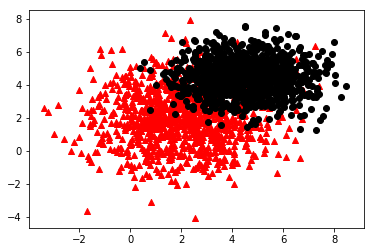

>epoch=0, error=62.833
>epoch=1, error=51.381
>epoch=2, error=50.438
>epoch=3, error=53.141
>epoch=4, error=50.754
>epoch=5, error=49.598
>epoch=6, error=28.425
>epoch=7, error=27.641
>epoch=8, error=33.882
>epoch=9, error=53.141
>epoch=10, error=49.960
>epoch=11, error=46.648
>epoch=12, error=53.141
>epoch=13, error=49.719
>epoch=14, error=46.648
>epoch=15, error=41.905
>epoch=16, error=47.202
>epoch=17, error=24.980
>epoch=18, error=33.466
>epoch=19, error=40.645
>epoch=20, error=53.141
>epoch=21, error=49.031
>epoch=22, error=44.272
>epoch=23, error=32.863
>epoch=24, error=37.683
>epoch=25, error=53.141
>epoch=26, error=48.456
>epoch=27, error=43.497
>epoch=28, error=26.981
>epoch=29, error=25.377
>epoch=30, error=36.277
>epoch=31, error=39.850
>epoch=32, error=45.343
>epoch=33, error=45.651
>epoch=34, error=30.594
>epoch=35, error=49.275
>epoch=36, error=46.648
>epoch=37, error=36.932
>epoch=38, error=39.497
>epoch=39, error=40.497
Error total para el conjunto de muestras: tensor(1

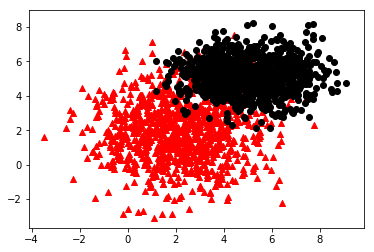

>epoch=0, error=55.172
>epoch=1, error=52.383
>epoch=2, error=51.884
>epoch=3, error=46.519
>epoch=4, error=52.802
>epoch=5, error=51.342
>epoch=6, error=48.249
>epoch=7, error=52.802
>epoch=8, error=50.990
>epoch=9, error=48.539
>epoch=10, error=23.409
>epoch=11, error=52.802
>epoch=12, error=50.478
>epoch=13, error=46.989
>epoch=14, error=26.153
>epoch=15, error=52.726
>epoch=16, error=49.719
>epoch=17, error=45.519
>epoch=18, error=25.534
>epoch=19, error=50.200
>epoch=20, error=48.456
>epoch=21, error=41.521
>epoch=22, error=19.900
>epoch=23, error=31.113
>epoch=24, error=34.293
>epoch=25, error=37.041
>epoch=26, error=40.000
>epoch=27, error=19.900
>epoch=28, error=26.077
>epoch=29, error=26.907
>epoch=30, error=40.100
>epoch=31, error=42.237
>epoch=32, error=22.627
>epoch=33, error=35.270
>epoch=34, error=37.523
>epoch=35, error=20.785
>epoch=36, error=19.698
>epoch=37, error=25.846
>epoch=38, error=26.153
>epoch=39, error=36.932
Error total para el conjunto de muestras: tensor(2

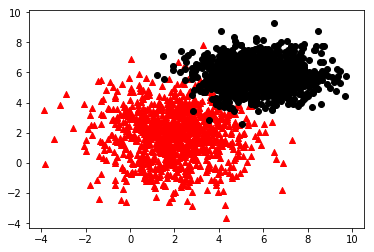

>epoch=0, error=49.598
>epoch=1, error=53.852
>epoch=2, error=51.108
>epoch=3, error=49.477
>epoch=4, error=53.329
>epoch=5, error=50.319
>epoch=6, error=49.477
>epoch=7, error=45.563
>epoch=8, error=53.329
>epoch=9, error=49.639
>epoch=10, error=48.166
>epoch=11, error=39.900
>epoch=12, error=51.730
>epoch=13, error=48.744
>epoch=14, error=46.519
>epoch=15, error=33.526
>epoch=16, error=29.120
>epoch=17, error=34.986
>epoch=18, error=23.917
>epoch=19, error=25.060
>epoch=20, error=21.909
>epoch=21, error=21.633
>epoch=22, error=20.000
>epoch=23, error=19.079
>epoch=24, error=18.762
>epoch=25, error=16.613
>epoch=26, error=17.889
>epoch=27, error=15.100
>epoch=28, error=16.371
>epoch=29, error=13.711
>epoch=30, error=18.221
>epoch=31, error=15.492
>epoch=32, error=17.205
>epoch=33, error=14.283
>epoch=34, error=17.550
>epoch=35, error=14.560
>epoch=36, error=17.321
>epoch=37, error=14.560
>epoch=38, error=18.330
>epoch=39, error=15.492
Error total para el conjunto de muestras: tensor(9

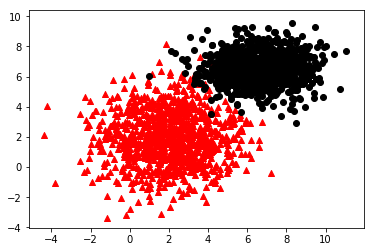

>epoch=0, error=51.962
>epoch=1, error=53.404
>epoch=2, error=51.498
>epoch=3, error=50.596
>epoch=4, error=19.183
>epoch=5, error=52.688
>epoch=6, error=51.147
>epoch=7, error=50.319
>epoch=8, error=45.475
>epoch=9, error=10.198
>epoch=10, error=8.944
>epoch=11, error=11.832
>epoch=12, error=10.198
>epoch=13, error=14.560
>epoch=14, error=14.142
>epoch=15, error=19.596
>epoch=16, error=27.203
>epoch=17, error=52.688
>epoch=18, error=50.398
>epoch=19, error=48.662
>epoch=20, error=42.190
>epoch=21, error=10.583
>epoch=22, error=8.485
>epoch=23, error=8.246
>epoch=24, error=8.485
>epoch=25, error=8.485
>epoch=26, error=8.485
>epoch=27, error=8.485
>epoch=28, error=8.246
>epoch=29, error=8.246
>epoch=30, error=8.246
>epoch=31, error=8.246
>epoch=32, error=8.246
>epoch=33, error=8.000
>epoch=34, error=8.000
>epoch=35, error=8.000
>epoch=36, error=8.000
>epoch=37, error=8.000
>epoch=38, error=8.000
>epoch=39, error=8.000
Error total para el conjunto de muestras: tensor(6.3246)
Conjunto de 

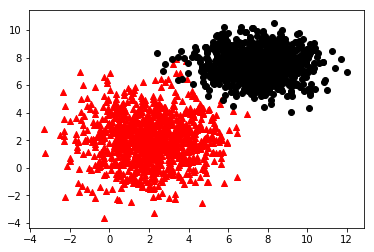

>epoch=0, error=53.479
>epoch=1, error=51.186
>epoch=2, error=50.912
>epoch=3, error=49.960
>epoch=4, error=44.811
>epoch=5, error=53.628
>epoch=6, error=50.359
>epoch=7, error=49.275
>epoch=8, error=46.605
>epoch=9, error=22.804
>epoch=10, error=35.270
>epoch=11, error=46.303
>epoch=12, error=27.276
>epoch=13, error=25.377
>epoch=14, error=36.166
>epoch=15, error=24.739
>epoch=16, error=33.823
>epoch=17, error=14.142
>epoch=18, error=11.489
>epoch=19, error=5.657
>epoch=20, error=5.292
>epoch=21, error=5.292
>epoch=22, error=5.657
>epoch=23, error=5.657
>epoch=24, error=5.292
>epoch=25, error=6.000
>epoch=26, error=5.292
>epoch=27, error=5.657
>epoch=28, error=5.292
>epoch=29, error=5.657
>epoch=30, error=5.657
>epoch=31, error=5.657
>epoch=32, error=5.292
>epoch=33, error=5.657
>epoch=34, error=5.657
>epoch=35, error=5.292
>epoch=36, error=5.657
>epoch=37, error=5.657
>epoch=38, error=5.657
>epoch=39, error=5.657
Error total para el conjunto de muestras: tensor(3.4641)
==============

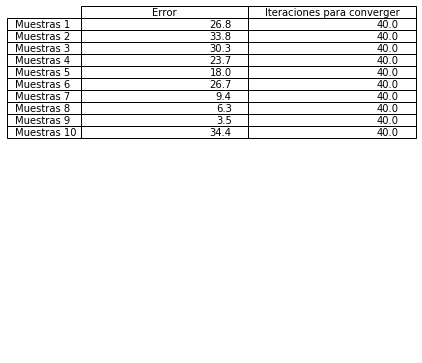

In [8]:
#Exercise 2.3.b

#Test with non-linearly separable data with high data blending
exercise2_3b(totalEpochs = 40, samplesPerClass = 1000, pmean2=[3, 3], tTitle="Datos no linealmente separables con mezcla mayor")


Conjunto de muestras 1


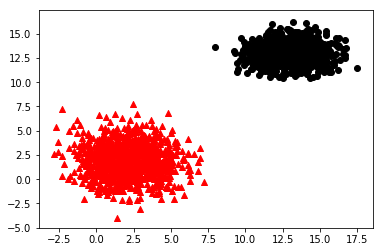

>epoch=0, error=41.037
>epoch=1, error=53.217
>epoch=2, error=52.154
>epoch=3, error=51.962
>epoch=4, error=51.536
>epoch=5, error=50.715
>epoch=6, error=48.291
>epoch=7, error=36.387
>epoch=8, error=2.000
>epoch=9, error=0.000
>epoch=10, error=0.000
>epoch=11, error=0.000
>epoch=12, error=0.000
>epoch=13, error=0.000
>epoch=14, error=0.000
>epoch=15, error=0.000
>epoch=16, error=0.000
>epoch=17, error=0.000
>epoch=18, error=0.000
>epoch=19, error=0.000
>epoch=20, error=0.000
>epoch=21, error=0.000
>epoch=22, error=0.000
>epoch=23, error=0.000
>epoch=24, error=0.000
>epoch=25, error=0.000
>epoch=26, error=0.000
>epoch=27, error=0.000
>epoch=28, error=0.000
>epoch=29, error=0.000
>epoch=30, error=0.000
>epoch=31, error=0.000
>epoch=32, error=0.000
>epoch=33, error=0.000
>epoch=34, error=0.000
>epoch=35, error=0.000
>epoch=36, error=0.000
>epoch=37, error=0.000
>epoch=38, error=0.000
>epoch=39, error=0.000
>epoch=40, error=0.000
>epoch=41, error=0.000
>epoch=42, error=0.000
>epoch=43, er

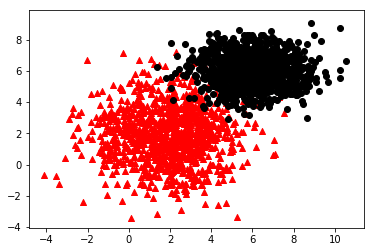

>epoch=0, error=59.833
>epoch=1, error=51.108
>epoch=2, error=48.621
>epoch=3, error=53.442
>epoch=4, error=50.794
>epoch=5, error=49.437
>epoch=6, error=43.955
>epoch=7, error=53.254
>epoch=8, error=49.800
>epoch=9, error=48.249
>epoch=10, error=41.085
>epoch=11, error=26.000
>epoch=12, error=34.756
>epoch=13, error=50.557
>epoch=14, error=48.539
>epoch=15, error=45.343
>epoch=16, error=32.619
>epoch=17, error=22.181
>epoch=18, error=24.900
>epoch=19, error=22.181
>epoch=20, error=24.980
>epoch=21, error=21.448
>epoch=22, error=23.152
>epoch=23, error=19.900
>epoch=24, error=20.298
>epoch=25, error=18.111
>epoch=26, error=14.697
>epoch=27, error=13.416
>epoch=28, error=11.314
>epoch=29, error=14.142
>epoch=30, error=11.314
>epoch=31, error=13.565
>epoch=32, error=11.662
>epoch=33, error=14.422
>epoch=34, error=11.314
>epoch=35, error=13.115
>epoch=36, error=12.166
>epoch=37, error=13.565
>epoch=38, error=11.489
>epoch=39, error=14.560
>epoch=40, error=11.489
>epoch=41, error=13.115
>e

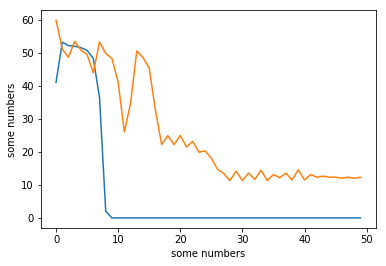

In [14]:
#Exercise 2.3c Test the Perceptron implementation
#Plot errors of two  
def exercise2_3c():

    totalEpochs = 50
    samplesPerClass = 1000
        
    # Sample data 1
    print("Conjunto de muestras 1")
    (TargetsA, SamplesA) = createData(numberSamplesPerClass = samplesPerClass, mean2 = [13, 13])
    finalErrorA, convergenceEpochA, allErrorA = testPerceptron(SamplesA, TargetsA, epochs = totalEpochs, testSize = 0.3)

    # Sample data 2
    print("Conjunto de muestras 2")
    (TargetsB, SamplesB) = createData(numberSamplesPerClass = samplesPerClass, mean2 = [6, 6])                                
    finalErrorB, convergenceEpochB, allErrorB = testPerceptron(SamplesB, TargetsB, epochs = totalEpochs, testSize = 0.3)
    
    return(allErrorA, allErrorB)

#Exercise 2.3.a
allErrorA, allErrorB = exercise2_3c()

print(allErrorA[49])

plt.plot(allErrorA.numpy())
plt.plot(allErrorB.numpy())
plt.xlabel('some numbers')
plt.ylabel('some numbers')
plt.show()
